# LIXO 
---

OCUPANTES

In [ ]:
async def run(self):
            '''
            se saida-> vai para saida
            se não random
            '''

            if self.clossest_exit()!= -1:
                EvacuationUI.update_agent_position(self.agent.name,self.clossest_exit())

            if self.agent.exits["Exit 1"] == 'closed':
                print(f"{self.agent.name} found Exit 1 clsoed, rerouting to another exit...")

            else:
                print(f"{self.agent.name} is heading to Exit 1")

            if self.agent.elevator == 'off':
                print(f"{self.agent.name} found the elevator off, will try to use stairs")


            await asyncio.sleep(2)

In [ ]:
async def clossest_exit(self):
            
            #get poss of ocupant based on name / name==poss na list
            poss_exits = EvacuationUI.exits_doors()

            ###ver caso não existam saídas(saida==curr_poss ou -1)-> andar aleatóriamente
            if not poss_exits:return -1

            x, y = EvacuationUI.occupants_loc[self.name] #[x, y]

            #ver prioridade -> mais á frente... :)

            dist = EvacuationUI.grid_size + 1
            i = 0
            p_dist = -1

            for i in range(poss_exits):
                x1 = poss_exits[i][0]
                y1 = poss_exits[i][1]
                if np.sqrt((x-x1)**2 + (y-y1)**2)<dist:
                    dist = np.sqrt((x-x1)**2 + (y-y1)**2)
                    p_dist = i

            return poss_exits[p_dist][0], poss_exits[p_dist][1]

        def find_path(self, target):
            
            
            open_set = []
            position = self.environment.get_occupant_loc(self.jid)
            heapq.heappush(open_set, (0, position))  # Priority queue with (cost, position)
            came_from = {}
            g_score = {position: 0}
            f_score = {position: self.heuristic(position, target)}

            while open_set:
                _, current = heapq.heappop(open_set)

                # Exit reached
                if current == target:  
                    #o occ guarda o caminho q quer fazer 
                    self.path = self.reconstruct_path(came_from, current)
                    return self.path



                x, y = current
                neighbors = self.astar_possible_moves(x, y) #where he can walk to(they are poss moves)
                for nx, ny in neighbors:
                    tentative_g_score = g_score[current] + 1
                    if tentative_g_score < g_score.get((nx, ny), float('inf')):
                        came_from[(nx, ny)] = current
                        g_score[(nx, ny)] = tentative_g_score
                        f_score[(nx, ny)] = tentative_g_score + self.heuristic((nx, ny), target)

                        # Avoid duplicates in the open_set
                        if (nx, ny) not in f_score:
                            heapq.heappush(open_set, (f_score[(nx, ny)], (nx, ny)))

            return None  # No path found

        def heuristic(self, a, b):
            
            return np.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)

        def reconstruct_path(self, came_from, current):
            
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.reverse()
            return path


    class CheckForHealthState(CyclicBehaviour):
        async def run(self):
            while(not self.agent.busy):
                await asyncio.sleep(1)
            await self.ask_health_state()
            await asyncio.sleep(10)

        async def ask_health_state(self):
            num_occupants = self.agent.environment.num_occupants
            for i in range(num_occupants):
                id = f"occupant{i}@localhost"
                if str(id) in self.agent.environment.occupants_loc.keys():
                    print(f"ER Agent {self.agent.jid} ks sending message to {id}")
                    msg = Message(to=f"occupant{i}@localhost")
                    msg.set_metadata("performative", "informative")
                    msg.body = "[ER] Please give me information on your health state"

                    await self.send(msg)


    class ReceiveHealthState(CyclicBehaviour):
        async def run(self):
            to_help_list = []
            while True:  # Continuously listen for messages
                await self.receive_health_state(to_help_list)
                #[id, healf, x, y, z]


        async def receive_health_state(self, to_help_list):
            '''
            se occ tiver no pick da health, não pede ajuda, só foge
            '''
            msg = await self.receive(timeout=10)  # Wait for a message with a 10-second timeout

            if msg:
                # Assuming msg.body contains the message text
                content = msg.body  # or msg.content, depending on the message library

                # Split the message by semicolons to isolate sections
                parts = content.split(";")

                try:
                    # Extract `id`
                    id_part = parts[0].split(":")[1].strip()

                    # Extract `position` (x, y, z) - splitting by `:` and `,`
                    position_part = parts[1].split(":")[1].strip()
                    x, y, z = map(int, position_part.strip("()").split(","))

                    # Extract `health state`
                    health_state_part = parts[2].split(":")[1].strip()
                    health_state = int(health_state_part)

                    # Create the array with agent data
                    occ = [id_part, health_state, x, y, z]

                    print(f"Agent data Received by ER Agent:\n - Id: {occ[0]};\n - Health State: {occ[1]};\n - Position:{occ[2],occ[3],occ[4]}")
                    to_help_list.append(occ)

                    if health_state==1: #agent é curável
                        cure_behaviour = self.Cure(occ, to_help_list)
                        self.agent.add_behaviour(cure_behaviour)

                except IndexError as e:
                    print("Failed to parse message. Make sure the message format is correct:", e)
                except ValueError as e:
                    print("Failed to convert data to integers. Check the data format:", e)



        # se ff -> o occ já foi visto por um médico(não sofre dano ao longo do tempo)
        async def clear_path(self, vetor):
            '''
            se houver um problema de dimenções pequenas eles podem fazer com que ele desapareça
            tem q ser no msm andar

            a função é chamada quando se encontra fogo no caminho

            recebe o vetor da direção, e vê 7 casas à frente e só apaga o fogo se houver pelo menos
            um quadrado não em chamas(apaga enguanto passa)
            '''
            #vetor = [1, -1] exemplo
            x, y, z = self.agent.environment.get_er_loc(self.agent.jid)
            can = 1
            while [x+can*vetor[0], y+can*vetor[1], z] in self.agent.environment.obstacles[x+can*vetor[0], y+can*vetor[1], z]:
                can+=1
            if can!=7:
                self.make_wave(vetor)

        async def make_wave(self, vector):

            x, y, z = self.agent.environment.get_er_loc(self.agent.jid)

            can = 1
            while [x+can*vector[0], y+can*vector[1], z] in self.agent.environment.obstacles[x+can*vector[0], y+can*vector[1], z]:
                can+=1
                self.agent.environment.obstacles.pop(x+can*vector[0], y+can*vector[1], z)

            pass


---

BUILDING_AGENT

----

EMERGENCY_RESPONDER

---

GRAFICOS
------

----------------


In [17]:
import matplotlib.pyplot as plt

def plot_graph(x, y, title="Graph", xlabel="X-axis", ylabel="Y-axis"):
    """
    Plots a graph given arrays for x and y, with most elements styled in baby pink 
    and the legend labels in mint green.

    Args:
        x (list or array-like): Array of x-coordinates.
        y (list or array-like): Array of y-coordinates.
        title (str): Title of the graph.
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis.
    
    Returns:
        None
    """
    if len(x) != len(y):
        raise ValueError("x and y must have the same length.")
    
  
    verde_escuro = "#0e4714"
    amarelo = "#f6bc2d"
    beje = "#e9eae0"

    plt.figure(figsize=(7, 4.5),  facecolor=beje)  # Set the figure size
    plt.plot(x, y, marker="o", linestyle="-", color=amarelo, label="Data")  # Baby pink line
    
    # Title and labels in baby pink
    plt.title(title, fontsize=16, color=amarelo)
    plt.xlabel(xlabel, fontsize=14, color=verde_escuro)
    plt.ylabel(ylabel, fontsize=14, color=verde_escuro)
    
    # Customize the tick parameters to baby pink
    plt.tick_params(axis='both', colors=verde_escuro, labelsize=12)
    
    # Customize the spines (axes borders) to baby pink
    ax = plt.gca()  # Get current axes
    ax.set_facecolor(beje)
    ax.spines['top'].set_color(verde_escuro)
    ax.spines['bottom'].set_color(verde_escuro)
    ax.spines['left'].set_color(verde_escuro)
    ax.spines['right'].set_color(verde_escuro)
    
    # Customize grid lines to baby pink
    plt.grid(True, color=verde_escuro, linestyle='--', linewidth=0.5)

    # Customizing the legend
    legend = plt.legend(fontsize=12)  # Show legend
    for text in legend.get_texts():  # Change text color in legend
        text.set_color(verde_escuro)

    plt.show()  # Display the graph


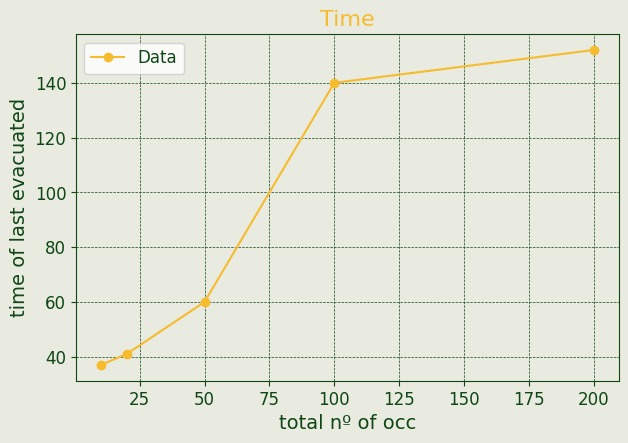

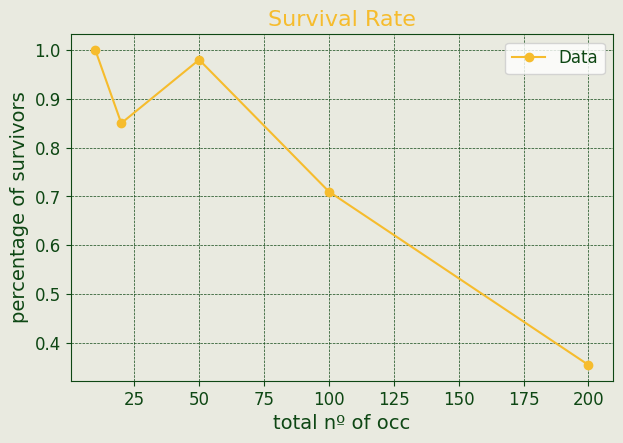

In [4]:
'''
altering nº of occ
    vab independ(x) nº of occ
    vab depend(y)   time of evacuation

    vab depend(y)   ratio of dead
'''
x =  [10, 20, 50, 100, 200]
y1 = [37, 41, 60, 140, 152] #Time
y2 = [10/10, 17/20, 49/50, 71/100, 71/200]

plot_graph(x, y1,title="Time", xlabel="total nº of occ", ylabel="time of last evacuated")

plot_graph(x, y2,title="Survival Rate", xlabel="total nº of occ", ylabel="percentage of survivors")

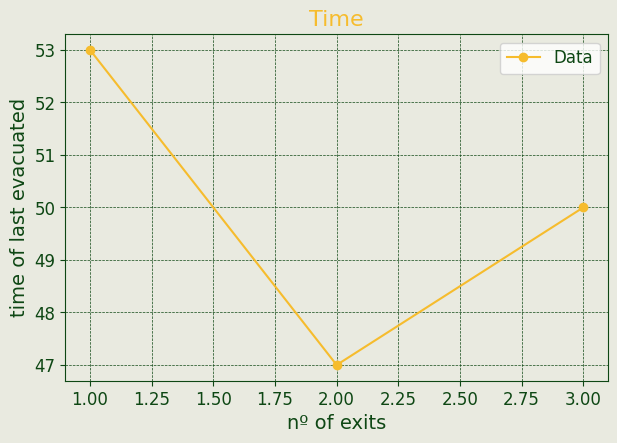

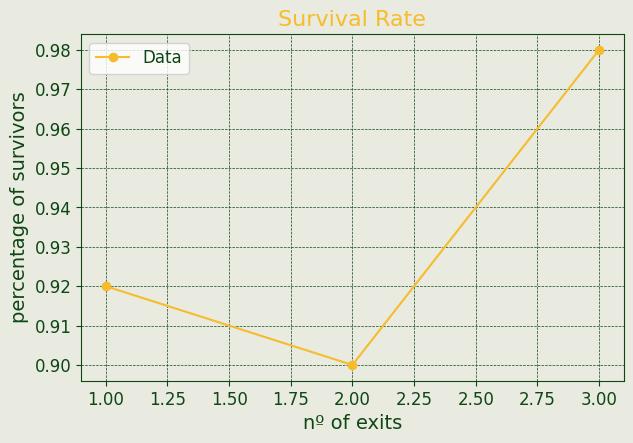

In [18]:
x =  [1, 2, 3]
y1 = [53, 47, 50] #Time
y2 = [46/50, 45/50, 49/50]

plot_graph(x, y1,title="Time", xlabel="nº of exits", ylabel="time of last evacuated")

plot_graph(x, y2,title="Survival Rate", xlabel="nº of exits", ylabel="percentage of survivors")

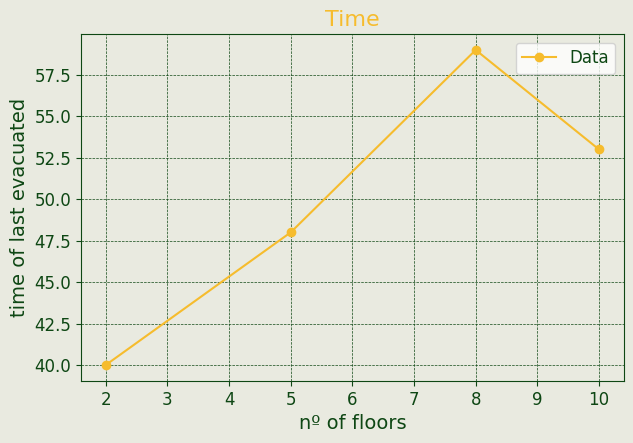

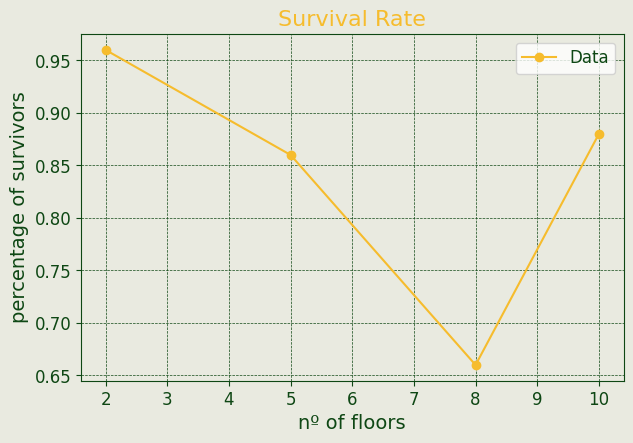

In [7]:
x =  [2, 5, 8, 10]
y1 = [40, 48, 59, 53] #Time
y2 = [48/50, 43/50, 33/50, 44/50]

plot_graph(x, y1,title="Time", xlabel="nº of floors", ylabel="time of last evacuated")

plot_graph(x, y2,title="Survival Rate", xlabel="nº of floors", ylabel="percentage of survivors")

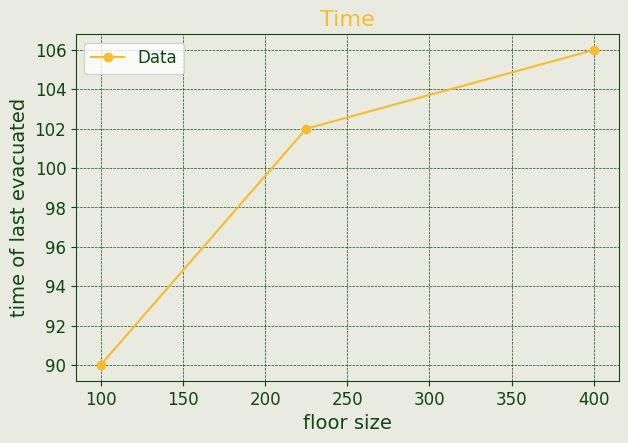

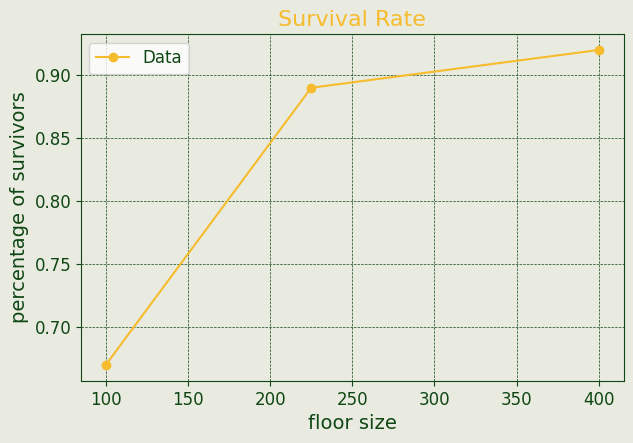

In [9]:
x =  [10*10, 15*15, 20*20]
y1 = [90, 102, 106] #Time
y2 = [67/100, 89/100, 92/100]

plot_graph(x, y1,title="Time", xlabel="floor size", ylabel="time of last evacuated")

plot_graph(x, y2,title="Survival Rate", xlabel="floor size", ylabel="percentage of survivors")

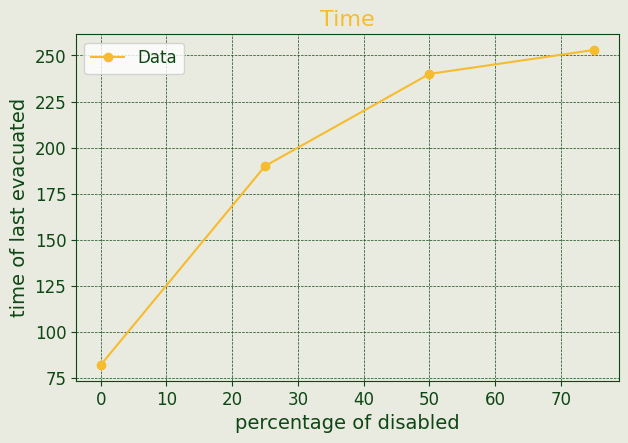

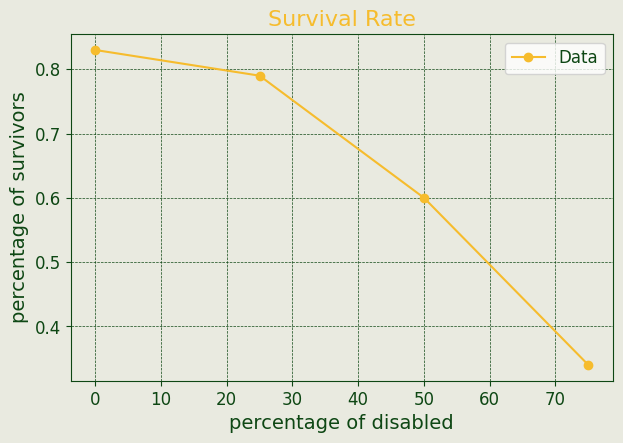

In [11]:
x =  [0, 25, 50, 75]
y1 = [82, 190, 240, 253] #Time
y2 = [83/100, 79/100, 60/100, 34/100]

plot_graph(x, y1,title="Time", xlabel="percentage of disabled", ylabel="time of last evacuated")

plot_graph(x, y2,title="Survival Rate", xlabel="percentage of disabled", ylabel="percentage of survivors")

In [20]:
import matplotlib.pyplot as plt

def plot_bar_graph(x, y, title="Graph", xlabel=" ", ylabel="Y-axis"):
    """
    Plots a graph given arrays for x and y, with most elements styled in baby pink 
    and the legend labels in mint green.

    Args:
        x (list or array-like): Array of x-coordinates.
        y (list or array-like): Array of y-coordinates.
        title (str): Title of the graph.
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis.
    
    Returns:
        None
    """
    if len(x) != len(y):
        raise ValueError("x and y must have the same length.")
    
  
    verde_escuro = "#0e4714"
    amarelo = "#f6bc2d"
    beje = "#e9eae0"

    plt.figure(figsize=(7, 4.5),  facecolor=beje)  # Set the figure size
    #plt.plot(x, y, marker="o", linestyle="-", color=amarelo, label="Data")  # Baby pink line
    plt.bar(x, y,color=amarelo)
    # Title and labels in baby pink
    plt.title(title, fontsize=16, color=amarelo)
    plt.xlabel(xlabel, fontsize=14, color=verde_escuro)
    plt.ylabel(ylabel, fontsize=14, color=verde_escuro)
    
    # Customize the tick parameters to baby pink
    plt.tick_params(axis='both', colors=verde_escuro, labelsize=12)
    
    # Customize the spines (axes borders) to baby pink
    ax = plt.gca()  # Get current axes
    ax.set_facecolor(beje)
    ax.spines['top'].set_color(verde_escuro)
    ax.spines['bottom'].set_color(verde_escuro)
    ax.spines['left'].set_color(verde_escuro)
    ax.spines['right'].set_color(verde_escuro)
    
    # Customize grid lines to baby pink
    plt.grid(True, color=verde_escuro, linestyle='--', linewidth=0.5)

    # Customizing the legend
    legend = plt.legend(fontsize=12)  # Show legend
    for text in legend.get_texts():  # Change text color in legend
        text.set_color(verde_escuro)

    plt.show()  # Display the graph


C:\Users\Daniela\AppData\Local\Temp\ipykernel_18300\2250274157.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  legend = plt.legend(fontsize=12)  # Show legend


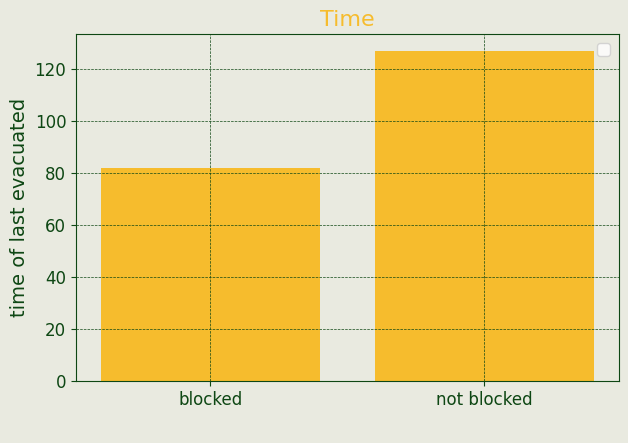

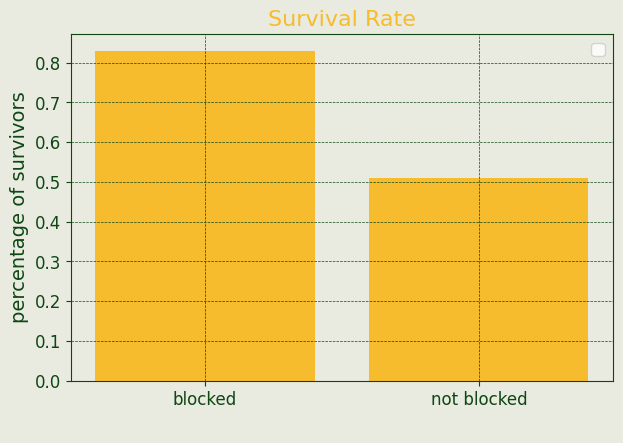

In [21]:
x =  ["blocked", "not blocked"]
y1 = [82, 127] #Time
y2 = [83/100, 51/100]

plot_bar_graph(x, y1,title="Time", ylabel="time of last evacuated")

plot_bar_graph(x, y2,title="Survival Rate", ylabel="percentage of survivors")